In [8]:
import torch
import torch.nn as nn
import torch.functional as F

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from options import Options
from models import *
from dataset import *
from utils import *

In [9]:
import os
try:
    os.chdir('workspace')
except:
    pass

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
model_folder = f"models/ECG/0.04/SmoothCNN_pct0.1_/"

opt = Options()
opt.load_options(model_folder)

Dataset = Datasets[opt.dataset]
model = Models[opt.model](opt)

state = torch.load(f"{model_folder}/latest.pth")
history = torch.load(f"{model_folder}/history.pth")

train_df = pd.read_csv(f"{opt.data_folder}/train.csv", header=None)
test_df = pd.read_csv(f"{opt.data_folder}/test.csv", header=None)

train_set = Dataset(train_df)
test_set = Dataset(test_df)

train_loader = DataLoader(train_set, batch_size=30, shuffle=True)
test_loader = DataLoader(test_set, batch_size=30, shuffle=True)

model.load_state_dict(state['state_dict'])

<All keys matched successfully>

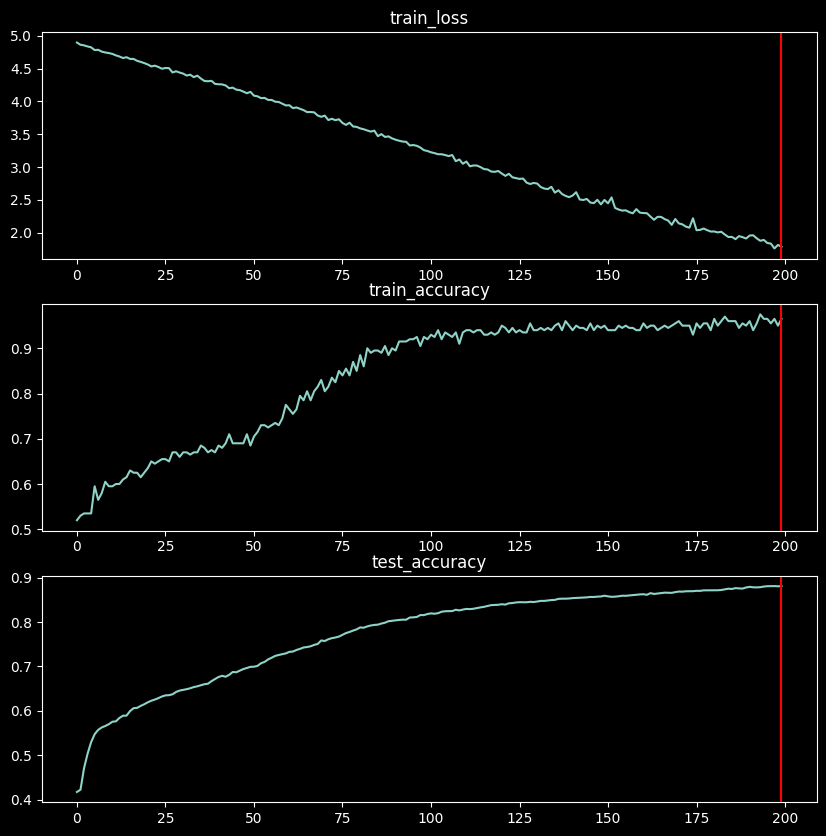

In [12]:
# model = model.to(device)
fig, axs = plt.subplots(len(history),1,figsize=(10,10))
test_best = state['epoch']

for i, key in enumerate(history.keys()):
    ax = axs[i]
    ax.set_title(key)

    ax.plot(history[key])
    ax.axvline(test_best, color='red')

Text(0.5, 1.0, 'Label = 1.0')

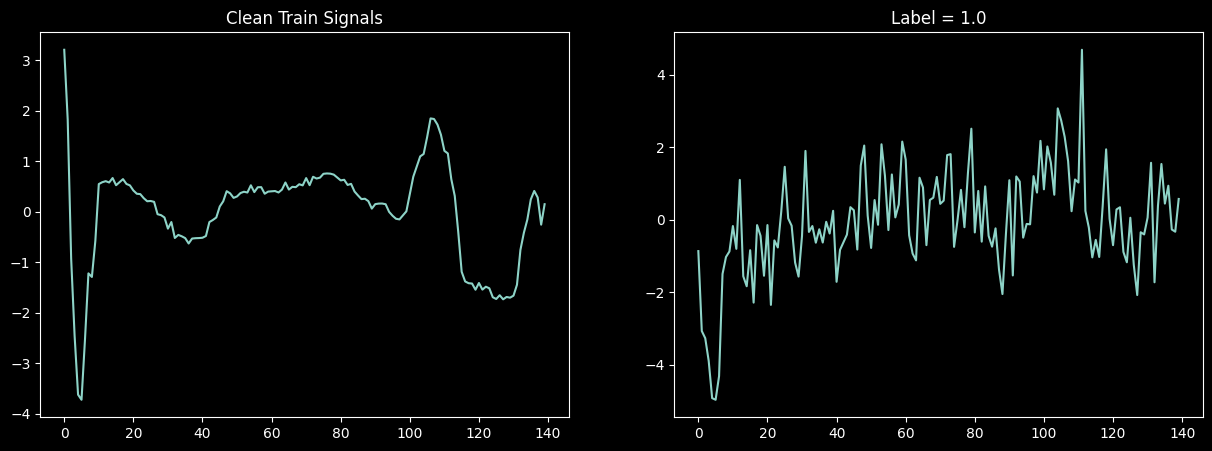

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(train_df.iloc[0, range(140)], label= f"{train_df.iloc[0, -1]}")
ax1.set_title(f"Clean Train Signals")

ax2.plot(test_df.iloc[0, range(140)], label= f"{test_df.iloc[0, -1]}")
ax2.set_title(f"Label = {test_df.iloc[0, -1]}")

In [14]:
# Confusion matrix and accuracies

y_pred, y_test, test_accuracy = predict(model, test_loader)
print(test_accuracy)

0.8809920800333473


              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2003
           1       0.95      0.84      0.89      2795

    accuracy                           0.88      4798
   macro avg       0.88      0.89      0.88      4798
weighted avg       0.89      0.88      0.88      4798



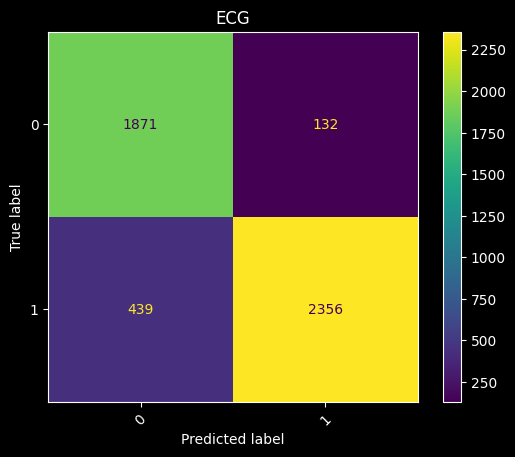

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation = 45)
plt.title(f"{model_folder.split('/')[1]}")
print(classification_report(y_test, y_pred))

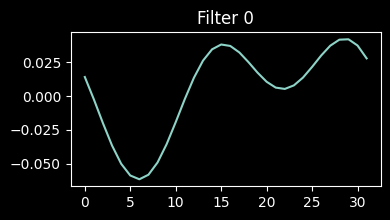

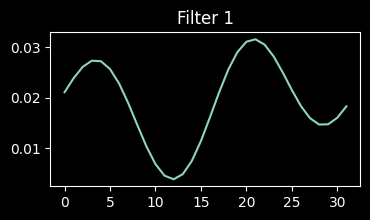

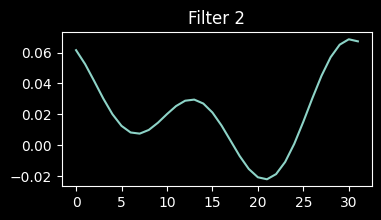

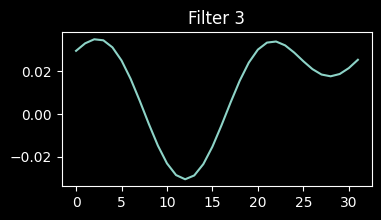

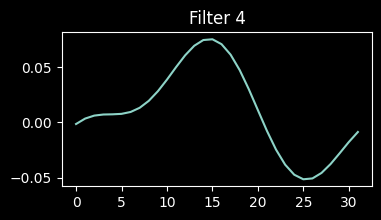

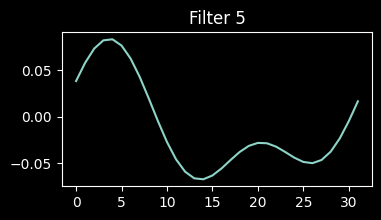

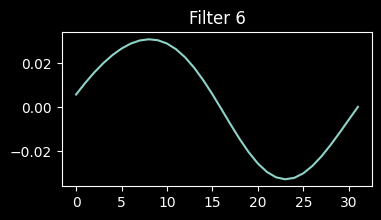

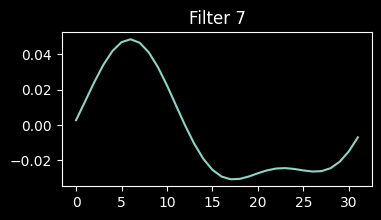

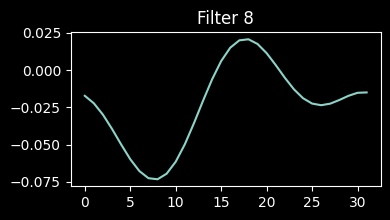

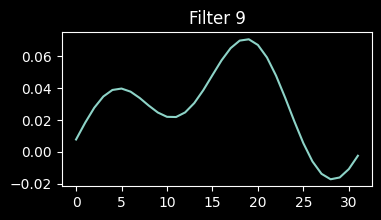

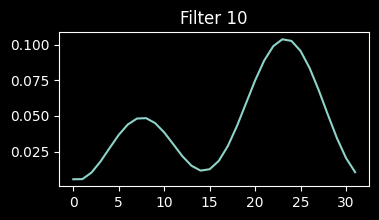

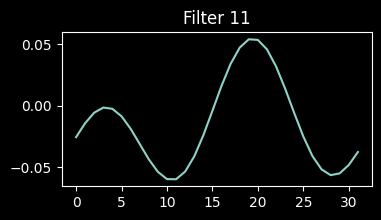

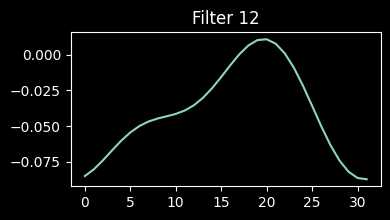

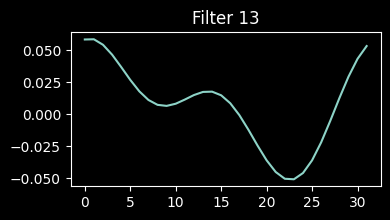

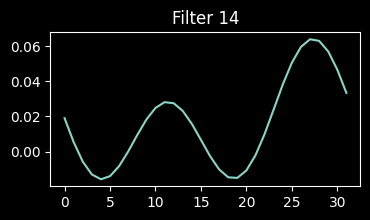

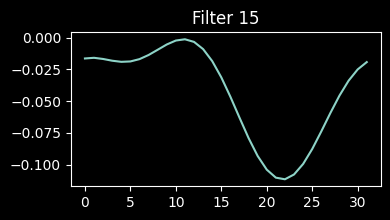

In [16]:
if opt.model == 'CNN':
    for i, filter in enumerate(model.features.conv_layer.weight.real):
        plt.figure(figsize=(4,2))
        plt.title(f"Filter {i}")
        plt.plot(filter[0].detach().numpy())
        plt.show()

else:
    for i, filter in enumerate(model.features.conv_layer.freqs):
        plt.figure(figsize=(4,2))
        plt.title(f"Filter {i}")
        plt.plot(torch.fft.ifft(filter[0]).real.detach().numpy())
        # plt.stem(filter[0].real.detach().numpy())
        plt.show()